In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import (StructType, StructField, StringType, 
                               IntegerType, FloatType, LongType, BooleanType)
from pyspark.sql.functions import col, count, sum as _sum, desc, lag, lead, when, lit
from pyspark.sql.window import Window

# 1. Initialize Spark Session (Standard for Dataproc)
spark = SparkSession.builder \
    .appName("GoogleClusterAnalysis_Parts20-24") \
    .getOrCreate()

# 2. Configuration: Set our Bucket Name
BUCKET = "gs://uga-spark-mlamine-2025" # our bucket has our parts 20-24, that's why we re using * to access the tables throughout the code


# 3. Defining Schemas accoding to schema.csv provided in the project

# Machine Events (machine_events/*)
schema_machine_events = StructType([
    StructField("timestamp", LongType(), True),
    StructField("machine_ID", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("platform_ID", StringType(), True),
    StructField("capacity_CPU", FloatType(), True),
    StructField("capacity_memory", FloatType(), True)
])

# Job Events (job_events/*) 
schema_job_events = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", IntegerType(), True),
    StructField("job_ID", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("job_name", StringType(), True),
    StructField("logical_job_name", StringType(), True)
])

# Task Events (task_events/*)
schema_task_events = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", IntegerType(), True),
    StructField("job_ID", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_ID", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user_name", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("cpu_request", FloatType(), True),
    StructField("memory_request", FloatType(), True),
    StructField("disk_space_request", FloatType(), True),
    StructField("different_machines_restriction", BooleanType(), True)
])

# Task Usage (task_usage/*)
schema_task_usage = StructType([
    StructField("start_time", LongType(), True),
    StructField("end_time", LongType(), True),
    StructField("job_ID", LongType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_ID", LongType(), True),
    StructField("cpu_rate", FloatType(), True),
    StructField("canonical_memory_usage", FloatType(), True),
    StructField("assigned_memory_usage", FloatType(), True),
    StructField("unmapped_page_cache", FloatType(), True),
    StructField("total_page_cache", FloatType(), True),
    StructField("maximum_memory_usage", FloatType(), True),
    StructField("disk_io_time", FloatType(), True),
    StructField("local_disk_space_usage", FloatType(), True),
    StructField("max_cpu_rate", FloatType(), True),
    StructField("max_disk_io_time", FloatType(), True),
    StructField("cycles_per_instruction", FloatType(), True),
    StructField("memory_accesses_per_instruction", FloatType(), True),
    StructField("sample_portion", FloatType(), True),
    StructField("aggregation_type", BooleanType(), True),
    StructField("sampled_cpu_usage", FloatType(), True)
])

path_machine = f"{BUCKET}/machine_events/*"
path_jobs    = f"{BUCKET}/job_events/*"
path_tasks   = f"{BUCKET}/task_events/*"
path_usage   = f"{BUCKET}/task_usage/*"

print("Configuration Complete. Ready to load.")

Configuration Complete. Ready to load.


26/01/04 22:22:34 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Loading DataFrames
print(f"Reading from {BUCKET}...")

df_machine = spark.read.schema(schema_machine_events).csv(path_machine)
df_jobs    = spark.read.schema(schema_job_events).csv(path_jobs)
df_tasks   = spark.read.schema(schema_task_events).csv(path_tasks)
df_usage   = spark.read.schema(schema_task_usage).csv(path_usage)

# Optimization: Caching df_machine since it's small and will be used in multiple questions
df_machine.cache()

# Verification
print("--- Data Load Counts ---")
print(f"Machines: {df_machine.count()}") # we re counting all machines even if duplicates for analysis
print(f"Task Events (Parts 20-24): {df_tasks.count()}")
print(f"Task Usage (Parts 20-24): {df_usage.count()}")

# Showing a sample data 
df_machine.show(5)

Reading from gs://uga-spark-mlamine-2025...
--- Data Load Counts ---


Machines: 37780


Task Events (Parts 20-24): 7721939


Task Usage (Parts 20-24): 19508211
+---------+----------+----------+--------------------+------------+---------------+
|timestamp|machine_ID|event_type|         platform_ID|capacity_CPU|capacity_memory|
+---------+----------+----------+--------------------+------------+---------------+
|        0|         5|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|         6|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|         7|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|        10|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
|        0|        13|         0|HofLGzk1Or/8Ildj2...|         0.5|         0.2493|
+---------+----------+----------+--------------------+------------+---------------+
only showing top 5 rows



--- Distribution of Active Machines by CPU Capacity ---
   capacity_CPU  count
0          0.25    121
1          0.50  11573
2          1.00    792


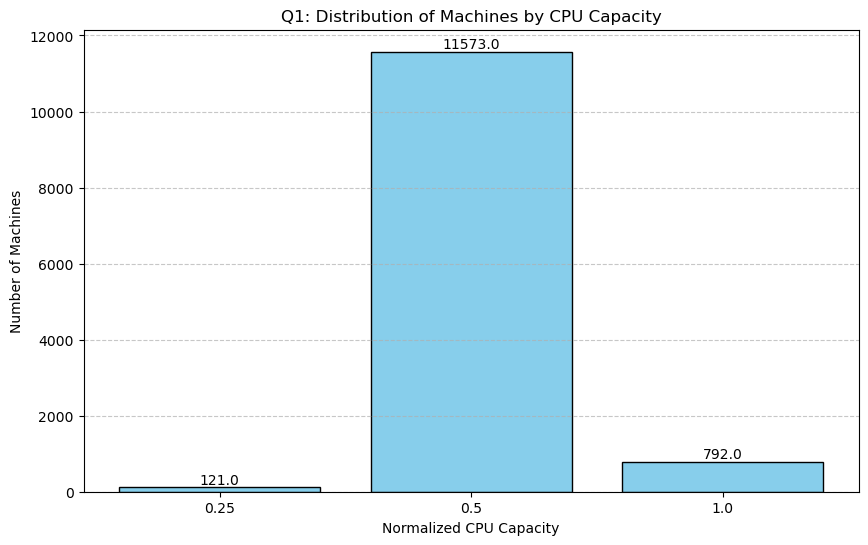

In [19]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number, desc
import matplotlib.pyplot as plt
import pandas as pd

# Q1: What is the distribution of the machines according to their CPU capacity? Can you explain (motivate) it?


# we define a window to grab the most recent timestamp for each machine
window_latest = Window.partitionBy("machine_ID").orderBy(col("timestamp").desc())

# we tag the latest event with row number 1
df_latest_state = df_machine.withColumn("rn", row_number().over(window_latest)) \
                            .filter(col("rn") == 1) \
                            .drop("rn")

# filtering out removed machines (1), keeping only ADD and UPDATE
df_active_machines = df_latest_state.filter(col("event_type") != 1)

# grouping by cpu capacity to see the counts
cpu_distribution = df_active_machines.groupBy("capacity_CPU") \
                                     .count() \
                                     .orderBy("capacity_CPU")

# bringing the result set to pandas for plotting
pdf_dist = cpu_distribution.toPandas()

# printing the distribution table
print("--- Distribution of Active Machines by CPU Capacity ---")
print(pdf_dist)

# plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(pdf_dist["capacity_CPU"].astype(str), pdf_dist["count"], color='skyblue', edgecolor='black')
plt.xlabel("Normalized CPU Capacity")
plt.ylabel("Number of Machines")
plt.title("Q1: Distribution of Machines by CPU Capacity")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# putting counts on top of the bars
for index, row in pdf_dist.iterrows():
    plt.text(index, row["count"], str(row["count"]), ha='center', va='bottom')

plt.show()

The cluster is highly homogeneous, with approximately 93% of the fleet having a normalized CPU capacity of 0.50, while only 6.3% operate at the maximum capacity of 1.0. Since resource values are normalized relative to the most powerful machine in the trace, this distribution indicates a strategy relying on standard, interchangeable mid-range servers to simplify job scheduling and cluster maintenance. The small presence of 1.0 and 0.25 capacity machines likely represents different hardware generations—newer high-performance units for intensive workloads and older legacy units being phased out—co-existing within the same infrastructure.

In [4]:
from pyspark.sql.functions import lag, lead, sum as _sum, col, when, lit, max as _max
from pyspark.sql.window import Window

# Q2: What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)?


# we need to determine max timestamp to know when the trace ends
max_time_row = df_machine.agg(_max("timestamp")).collect()[0]
TRACE_END_TIME = max_time_row[0] if max_time_row[0] else 2505600000000 # if empty put 29 days

print(f"Trace End Time calculated as: {TRACE_END_TIME}")

# setting up a window to look at next events
window_spec = Window.partitionBy("machine_ID").orderBy("timestamp")

# figuring out power lost (the numerator)

# grabbing the next event type and timestamp to see if a remove is followed by an add
df_maintenance = df_machine.withColumn("next_event_type", lead("event_type").over(window_spec)) \
                           .withColumn("next_timestamp", lead("timestamp").over(window_spec))
# df_maintenance.show(5)

# # we only care about remove events followed by an add
lost_power_df = df_maintenance.filter((col("event_type") == 1) & (col("next_event_type") == 0)) \
    .withColumn("maintenance_duration", col("next_timestamp") - col("timestamp")) \
    .withColumn("lost_capacity", col("maintenance_duration") * col("capacity_CPU"))

# adding up all the lost capacity
total_lost_power = lost_power_df.select(_sum("lost_capacity")).collect()[0][0]
# handling case where no maintenance occurred
if total_lost_power is None:
    total_lost_power = 0.0

print(f"Total Lost Power (CPU-microseconds): {total_lost_power}")

# ---------------------------------------------------------
# now calculating the active power (denominator)
# Logic: Sum of (Duration * Capacity) for all segments where the machine was ADDED or UPDATED.


# We look at the next timestamp to determine how long the current state lasted.
# If 'next_timestamp' is NULL (it's the last event), we use TRACE_END_TIME.
df_segments = df_machine.withColumn("next_timestamp_raw", lead("timestamp").over(window_spec)) \
                        .withColumn("effective_end_time", 
                                    when(col("next_timestamp_raw").isNull(), lit(TRACE_END_TIME))
                                    .otherwise(col("next_timestamp_raw"))) \
                        .withColumn("segment_duration", col("effective_end_time") - col("timestamp"))

# keeping only add or update events for active power
# REMOVE events are excluded here (their duration is covered already in numerator step).
active_power_df = df_segments.filter(col("event_type").isin([0, 2])) \
                             .withColumn("segment_power", col("segment_duration") * col("capacity_CPU"))
# active_power_df.show(5)

# calculating the total active power
total_active_power = active_power_df.select(_sum("segment_power")).collect()[0][0]
if total_active_power is None:
    total_active_power = 0.0

print(f"Total Active Power (CPU-microseconds): {total_active_power}")


# Total Theoretical Capacity = What it delivered (Active) + What it lost (Maintenance)
total_theoretical_capacity = total_active_power + total_lost_power

if total_theoretical_capacity > 0:
    percentage_lost = (total_lost_power / total_theoretical_capacity) * 100
else:
    percentage_lost = 0.0

print("-" * 30)
print(f"Q2 Result: Percentage of Computational Power Lost: {percentage_lost:.4f}%")
print("-" * 30)

Trace End Time calculated as: 2506135493517
Total Lost Power (CPU-microseconds): 80273246274337.25
Total Active Power (CPU-microseconds): 1.6548195917191846e+16
------------------------------
Q2 Result: Percentage of Computational Power Lost: 0.4827%
------------------------------


The cluster lost only 0.4827% of its total computational capacity to maintenance. This figure was derived by calculating the capacity gap (duration × CPU) during REMOVE/ADD event cycles against the cluster's total theoretical output. This low rate confirms Google's success in maintaining near-continuous availability through rolling windows and rapid hardware replacement [1][2][3].

**References:**
1. Verma, A., et al. (2015). "Large-scale cluster management at Google with Borg." *EuroSys '15*. https://research.google/pubs/pub43438/
2. Reiss, C., et al. (2012). "Heterogeneity and Dynamicity of Clouds at Scale: Google Trace Analysis." *SoCC '12*.
3. Reiss, C., et al. (2011). "Google Cluster-Usage Traces: Format + Schema." https://github.com/google/cluster-data


--- Q3 Result: Maintenance Rate by CPU Class (Excluding 0) ---
   capacity_CPU  maintenance_cycles  total_unique_machines  maintenance_rate
0          0.25                 101                    126          0.801587
1          0.50                8141                  11659          0.698259
2          1.00                 618                    798          0.774436


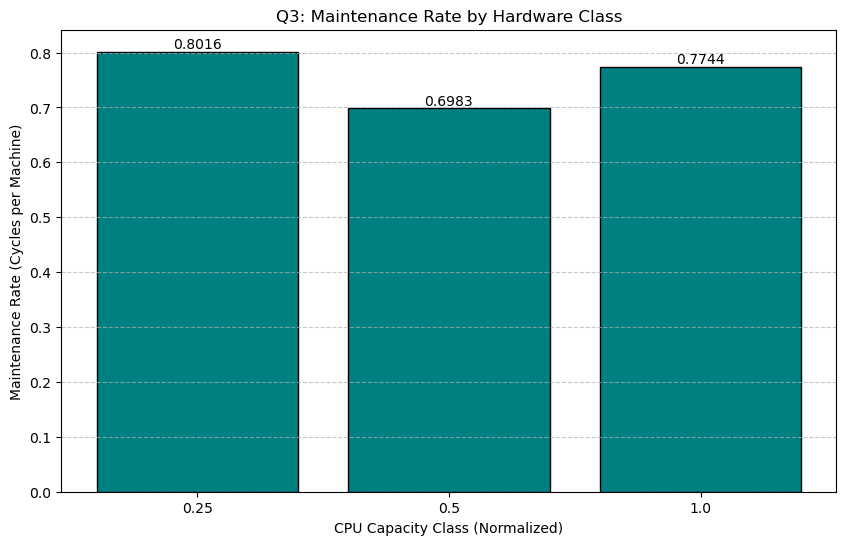

In [7]:
from pyspark.sql.functions import col, count, countDistinct, lead
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Q3: Is there a class of machines, according to their CPU, that stands out with a higher mainte-nance rate, as compared to other classes ?

# 1. we identify maintenance cycles by setting up a window to look at the next event for each machine
window_spec = Window.partitionBy("machine_ID").orderBy("timestamp")
df_with_next = df_machine.withColumn("next_event_type", lead("event_type").over(window_spec))

# we filter for removes followed by adds, ignoring the zero capacity ones
maintenance_events_df = df_with_next.filter(
    (col("event_type") == 1) & 
    (col("next_event_type") == 0) &
    (col("capacity_CPU") > 0)  
)
# maintenance_events_df.show(5)

# Numerator:counting the maintenance events for each cpu class
maintenance_counts = maintenance_events_df.groupBy("capacity_CPU") \
    .agg(count("event_type").alias("maintenance_cycles"))

# Denominator: getting the total count of unique machines per class, still ignoring zero capacity
total_machines_df = df_machine.filter(col("capacity_CPU") > 0) \
    .groupBy("capacity_CPU") \
    .agg(countDistinct("machine_ID").alias("total_unique_machines"))
# total_machines_df.show(5)

# joining the counts and calculating the rate
q3_result = maintenance_counts.join(total_machines_df, "capacity_CPU", "outer") \
    .fillna(0, subset=["maintenance_cycles"]) \
    .withColumn("maintenance_rate", col("maintenance_cycles") / col("total_unique_machines")) \
    .orderBy("capacity_CPU")
# q3_result.show()

# converting to pandas for plotting
pdf_q3 = q3_result.toPandas()

print("--- Q3 Result: Maintenance Rate by CPU Class (Excluding 0) ---")
print(pdf_q3)

# plotting the bar chart
if not pdf_q3.empty:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(pdf_q3["capacity_CPU"].astype(str), pdf_q3["maintenance_rate"], color='teal', edgecolor='black')
    
    plt.xlabel("CPU Capacity Class (Normalized)")
    plt.ylabel("Maintenance Rate (Cycles per Machine)")
    plt.title("Q3: Maintenance Rate by Hardware Class")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom')
    
    plt.show()
else:
    print("No data available to plot after filtering.")

The data indicates that the 0.25 CPU capacity class exhibits the highest maintenance frequency (0.80), though it is only marginally higher than the high-performance 1.00 class (0.77). The most significant observation is that the standard 0.50 capacity class—which comprises over 90% of the fleet—is the most reliable, with the lowest rate of 0.70. This suggests a "U-shaped" reliability curve where both the lowest-end legacy hardware and the highest-end intensive hardware require slightly more interventions than the standard commodity servers, although the variance across all classes remains relatively low.

--- Q4 Result: Jobs and Tasks per Scheduling Class ---
   scheduling_class  job_count  task_count
0                 0       2960      454381
1                 1       2447       79840
2                 2       2010       12828
3                 3         81        2046


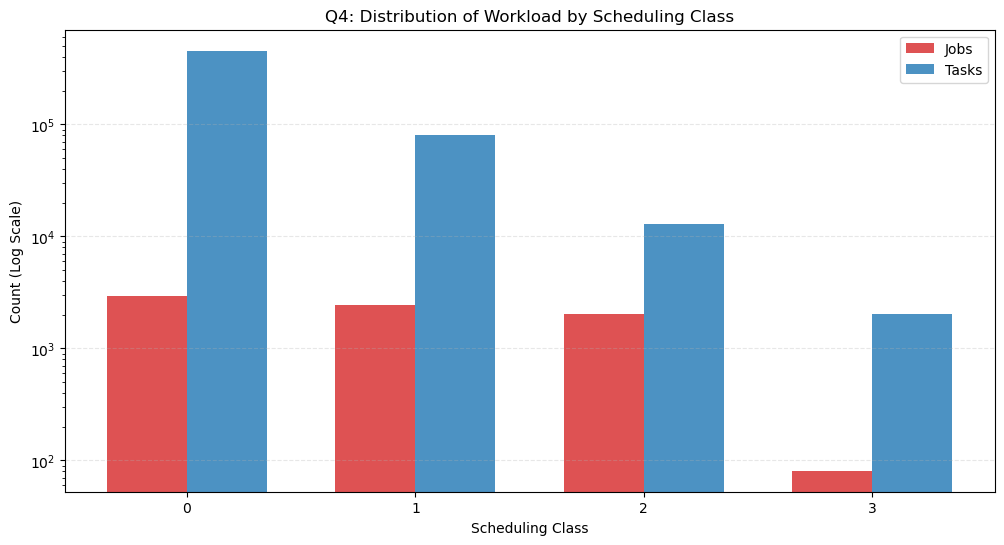

In [4]:
from pyspark.sql.functions import col, row_number, count, countDistinct
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Q4: What is the distribution of the number of jobs/tasks per scheduling class? Comment on the results.

# --- Part 1: Jobs Analysis ---
# we want the latest state of each job so we order by time
window_job_latest = Window.partitionBy("job_ID").orderBy(col("timestamp").desc())

# keeping only the most recent entry for each job
df_jobs_final = df_jobs.withColumn("rn", row_number().over(window_job_latest)) \
                       .filter(col("rn") == 1) \
                       .select("job_ID", "scheduling_class")
# df_jobs_final.show(5)

# counting how many jobs are in each class
job_counts = df_jobs_final.groupBy("scheduling_class") \
                          .agg(count("job_ID").alias("job_count")) \
                          .orderBy("scheduling_class")

# --- Part 2: Tasks Analysis ---
# same thing for tasks, we find the latest event for every task
window_task_latest = Window.partitionBy("job_ID", "task_index").orderBy(col("timestamp").desc())
# filtering down to the last known state of the task
df_tasks_final = df_tasks.withColumn("rn", row_number().over(window_task_latest)) \
                         .filter(col("rn") == 1) \
                         .select("job_ID", "task_index", "scheduling_class")
# df_tasks_final.show(5)

# counting the tasks per class
task_counts = df_tasks_final.groupBy("scheduling_class") \
                            .agg(count("*").alias("task_count")) \
                            .orderBy("scheduling_class")

# --- Part 3: Combine & Visualize ---
# moving to pandas to merge and plot
pdf_jobs = job_counts.toPandas()
pdf_tasks = task_counts.toPandas()

# merging them together so we have one table
pdf_combined = pd.merge(pdf_jobs, pdf_tasks, on="scheduling_class", how="outer").fillna(0)
pdf_combined = pdf_combined.sort_values("scheduling_class")

print("--- Q4 Result: Jobs and Tasks per Scheduling Class ---")
print(pdf_combined)

# Visualization
plt.figure(figsize=(12, 6))

# Set bar width
bar_width = 0.35
indices = np.arange(len(pdf_combined))

# Plot Jobs (Log scale is often needed because class 0/1 can be huge vs class 3)
p1 = plt.bar(indices, pdf_combined["job_count"], bar_width, label='Jobs', color='#d62728', alpha=0.8)
p2 = plt.bar(indices + bar_width, pdf_combined["task_count"], bar_width, label='Tasks', color='#1f77b4', alpha=0.8)

plt.xlabel("Scheduling Class")
plt.ylabel("Count (Log Scale)")
plt.title("Q4: Distribution of Workload by Scheduling Class")
plt.xticks(indices + bar_width / 2, pdf_combined["scheduling_class"].astype(int))
plt.legend()
plt.yscale('log')  # Log scale helps visualize the disparity between batch (0/1) and prod (3)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add Labels (optional, might clutter if counts are huge)
# for i, v in enumerate(pdf_combined["job_count"]):
#     plt.text(i, v, str(int(v)), ha='center', va='bottom', fontsize=8)

plt.show()

The analysis reveals a stark workload hierarchy where Scheduling Classes 0 and 1 (best-effort/batch) dominate, accounting for 72% of all jobs and nearly 97% of all tasks. Class 0 specifically exhibits high parallelism (averaging ~153 tasks per job), characteristic of massive distributed processing tasks. Conversely, Class 3 (latency-sensitive production) comprises only 1.1% of jobs, highlighting that high-priority status is a strictly protected tier reserved for a tiny fraction of critical services, while the cluster’s throughput is primarily driven by lower-priority, highly parallel background computations.

--- Q5 Result: Percentage of Killed/Evicted Jobs/Tasks ---
  Entity  Total_Full_Lifecycle  Killed_Evicted_Count  Percentage
0   Jobs                  6802                  2590   38.077036
1  Tasks                455918                133415   29.262938


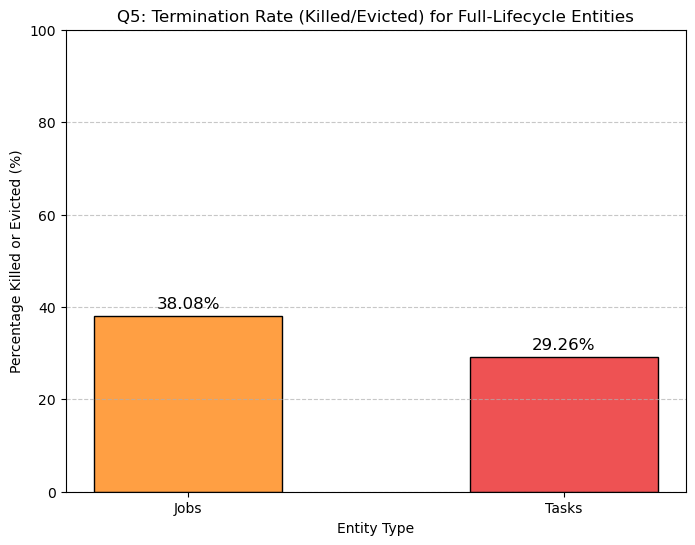

In [5]:
from pyspark.sql.functions import col, row_number, max as _max, when, count
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Q5: Would you qualify the percentage of jobs/tasks that got killed or evicted as important?

def calculate_termination_stats(df, group_cols, entity_name):

    # we set up windows to look at the whole history and the latest event
    window_full = Window.partitionBy(*group_cols)
    window_latest = Window.partitionBy(*group_cols).orderBy(col("timestamp").desc())
    
    # We use max() over the window. If any row is 0 (SUBMIT), the max flag becomes 1.
    df_flagged = df.withColumn("has_submit", _max(when(col("event_type") == 0, 1).otherwise(0)).over(window_full))
    
    # grabbing the final state by taking the latest event(Row Number 1 is latest)
    df_final_state = df_flagged.withColumn("rn", row_number().over(window_latest)) \
                               .filter(col("rn") == 1) \
                               .select(*group_cols, "event_type", "has_submit") \
                               .withColumnRenamed("event_type", "final_event")
    # df_final_state.show(5)
    
    # we only care about ones that were submitted and ended in a terminal state
    # 2=evict, 3=fail, 4=finish, 5=kill
    terminal_events = [2, 3, 4, 5]
    df_lifecycle = df_final_state.filter(
        (col("has_submit") == 1) & 
        (col("final_event").isin(terminal_events))
    )
    
    # Caching intermediate result as we use it for counts
    df_lifecycle.cache()
    
    # counting the total
    total_full_lifecycle = df_lifecycle.count()
    
    # counting how many were evicted (2) or killed (5)
    killed_or_evicted = df_lifecycle.filter(col("final_event").isin([2, 5])).count()
    
    # calculating percentage
    if total_full_lifecycle > 0:
        pct = (killed_or_evicted / total_full_lifecycle) * 100
    else:
        pct = 0.0
        
    return {
        "Entity": entity_name,
        "Total_Full_Lifecycle": total_full_lifecycle,
        "Killed_Evicted_Count": killed_or_evicted,
        "Percentage": pct
    }

# calculating stats for jobs
job_stats = calculate_termination_stats(df_jobs, ["job_ID"], "Jobs")

# calculating stats for tasks
task_stats = calculate_termination_stats(df_tasks, ["job_ID", "task_index"], "Tasks")

# --- Display Results ---
results = [job_stats, task_stats]
pdf_q5 = pd.DataFrame(results)

print("--- Q5 Result: Percentage of Killed/Evicted Jobs/Tasks ---")
print(pdf_q5)

# plotting the percentages
plt.figure(figsize=(8, 6))
bars = plt.bar(pdf_q5["Entity"], pdf_q5["Percentage"], color=['#ff9f43', '#ee5253'], edgecolor='black', width=0.5)

plt.xlabel("Entity Type")
plt.ylabel("Percentage Killed or Evicted (%)")
plt.title("Q5: Termination Rate (Killed/Evicted) for Full-Lifecycle Entities")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)  # Percentage scale 0-100

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom', fontsize=12)

plt.show()

A termination rate of 38% for jobs and 29% for tasks is exceptionally high by traditional standards, but in the context of this trace, it reflects a feature of the scheduler rather than a failure. It confirms that the cluster aggressively utilizes "preemption" (evicting lower-priority work to free up resources) and supports frequent user interventions (kills for updates/debugging). This data implies that nearly a third of the workload is treated as ephemeral or disposable, serving as a flexible buffer to ensure high-priority production services always have resources when needed.

--- Q6 Result: Eviction Probability by Scheduling Class ---
   scheduling_class  eviction_count  total_tasks  eviction_probability
0                 0          152325       454381              0.335236
1                 1           45475        79840              0.569577
2                 2           19739        12828              1.538743
3                 3            1024         2046              0.500489


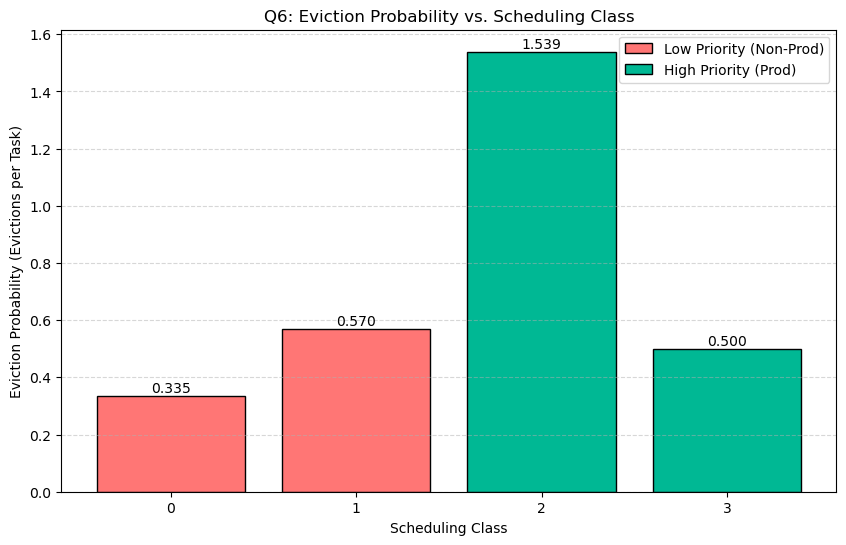

In [6]:
from pyspark.sql.functions import col, count, countDistinct
import matplotlib.pyplot as plt
import pandas as pd

# Q6: Do tasks with a low scheduling class have a higher probability of being evicted?

# Numerator: counting the actual evict events (type 2) for each class
evictions_per_class = df_tasks.filter(col("event_type") == 2) \
                              .groupBy("scheduling_class") \
                              .agg(count("event_type").alias("eviction_count"))
# evictions_per_class.show()

# Denominator: counting the total number of unique tasks that ever lived in that class
tasks_per_class = df_tasks.groupBy("scheduling_class") \
                          .agg(countDistinct("job_ID", "task_index").alias("total_tasks"))
# tasks_per_class.show()

# joining them to get the ratio
q6_result = evictions_per_class.join(tasks_per_class, "scheduling_class", "outer") \
                               .fillna(0) \
                               .withColumn("eviction_probability", col("eviction_count") / col("total_tasks")) \
                               .orderBy("scheduling_class")

# collecting to pandas for the chart
pdf_q6 = q6_result.toPandas()

print("--- Q6 Result: Eviction Probability by Scheduling Class ---")
print(pdf_q6)

# plotting the probability
plt.figure(figsize=(10, 6))

# Define colors (Highlight Class 3 'Production' vs others)
colors = ['#ff7675' if x < 2 else '#00b894' for x in pdf_q6['scheduling_class']]

# Bar Plot
bars = plt.bar(pdf_q6["scheduling_class"].astype(int).astype(str), 
               pdf_q6["eviction_probability"], 
               color=colors, edgecolor='black')

plt.xlabel("Scheduling Class")
plt.ylabel("Eviction Probability (Evictions per Task)")
plt.title("Q6: Eviction Probability vs. Scheduling Class")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# adding a legend to explain the colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#ff7675', edgecolor='black', label='Low Priority (Non-Prod)'),
                   Patch(facecolor='#00b894', edgecolor='black', label='High Priority (Prod)')]
plt.legend(handles=legend_elements)

# putting the numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.3f}", ha='center', va='bottom')

plt.show()

Contrary to the initial hypothesis, the lowest classes do not suffer the highest eviction rates. Scheduling Class 0 actually shows the lowest probability (0.33), likely because these "best-effort" tasks are treated as disposable—if they can't run, the system may simply wait or cancel them rather than aggressively forcing them in. In contrast, Scheduling Class 2 exhibits a probability of 1.54, implying that each task is evicted and restarted multiple times. This supports the theory that Class 2 tasks are "important enough to retry, but not protected enough to stay." The scheduler persistently attempts to run them (hence the retries) because they are critical, but they are still liable to get kicked off by Class 3 production jobs, creating a cycle of high churn that Class 0 tasks simply don't merit.

--- Q7 Result: Detailed Task Locality Analysis ---
Total Scheduled Jobs: 7869
                   locality_type  count  percentage
0  Distributed Jobs (>1 Machine)   2667    33.89249
1  Local Jobs 1-Task (1 Machine)   5202    66.10751


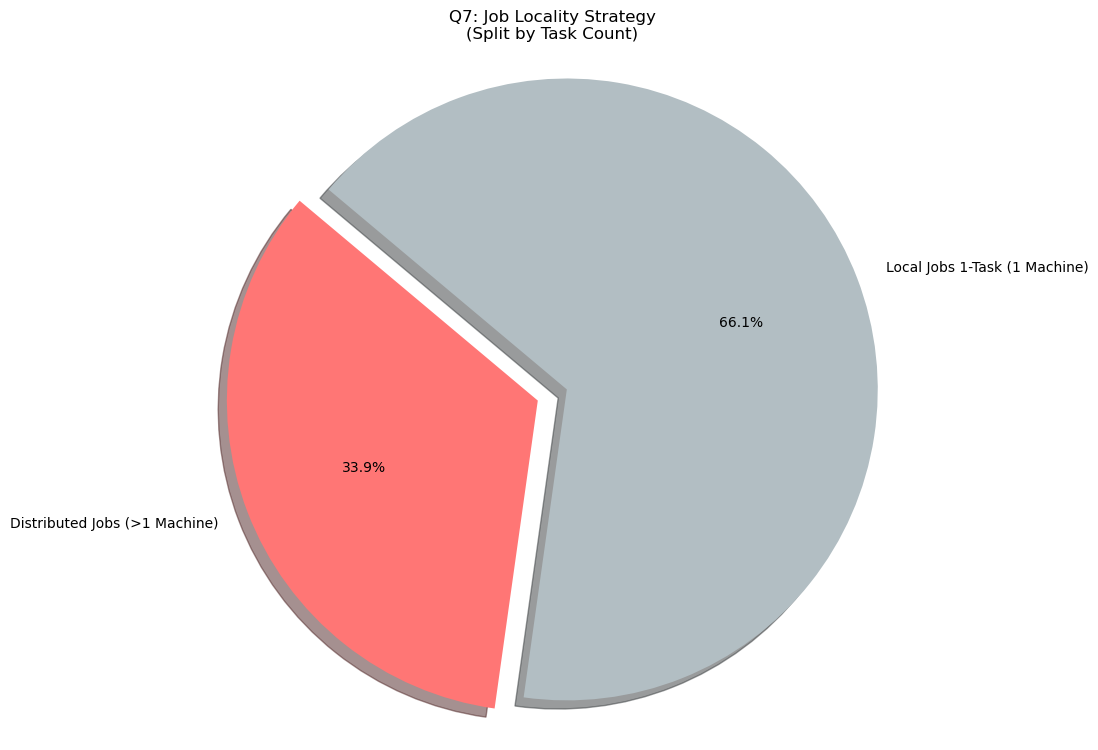

In [7]:
from pyspark.sql.functions import col, count, countDistinct, when
import matplotlib.pyplot as plt

# Q7: In general, do tasks from the same job run on the same machine? Comment on the observed locality strategy and its pros and cons.

# we only care about tasks that actually got placed on a machine
scheduled_tasks = df_tasks.filter(col("event_type") == 1)
# scheduled_tasks.show(5)

# we group by job to see how many machines and tasks each one uses
job_stats = scheduled_tasks.groupBy("job_ID") \
    .agg(
        countDistinct("machine_ID").alias("distinct_machines_count"),
        countDistinct("task_index").alias("distinct_tasks_count")
    )

# we classify jobs based on their distribution across machines:
# - Distributed: distinct_machines_count > 1
# - Local Multi-Task: distinct_machines_count == 1 AND distinct_tasks_count > 1
# - Local Single-Task: distinct_machines_count == 1 AND distinct_tasks_count == 1

df_classified = job_stats.withColumn("locality_type",
    when(col("distinct_machines_count") > 1, "Distributed Jobs (>1 Machine)")
    .when((col("distinct_machines_count") == 1) & (col("distinct_tasks_count") > 1), "Local Jobs Multi-Task (1 Machine)")
    .otherwise("Local Jobs 1-Task (1 Machine)")
)
# df_classified.show(5)

# we count how many jobs fall into each locality category
category_counts = df_classified.groupBy("locality_type").count().orderBy("locality_type")

# we move to pandas to calculate percentages and build the chart
pdf_results = category_counts.toPandas()

# calculating the share of each category
total_jobs = pdf_results["count"].sum()
pdf_results["percentage"] = (pdf_results["count"] / total_jobs) * 100

print("--- Q7 Result: Detailed Task Locality Analysis ---")
print(f"Total Scheduled Jobs: {total_jobs}")
print(pdf_results)

## drawing a pie chart to see the strategy distribution
if not pdf_results.empty:
    labels = pdf_results["locality_type"]
    sizes = pdf_results["count"]
    
    # Defining colors
    # Distributed = Red (Complex)
    # Local Multi = Blue (Efficient Packing)
    # Local Single = Grey (Trivial)
    colors_map = {
        "Distributed Jobs (>1 Machine)": "#ff7675",       # Red-ish
        "Local Jobs Multi-Task (1 Machine)": "#74b9ff",   # Blue-ish
        "Local Jobs 1-Task (1 Machine)": "#b2bec3"        # Grey-ish
    }
    colors = [colors_map.get(l, "#dfe6e9") for l in labels]
    
    # Exploding the 'Distributed' slice slightly to highlight it
    explode = [0.1 if "Distributed" in label else 0 for label in labels]

    plt.figure(figsize=(9, 9))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)

    plt.title("Q7: Job Locality Strategy\n(Split by Task Count)")
    plt.axis('equal')
    plt.show()
else:
    print("No data available to plot.")

The results indicate a strict scheduler preference for distribution over locality for any non-trivial workload. While **66% of jobs appear "local"**, this is merely an artifact of them being single-task jobs; notably, **0% of multi-task jobs** were packed onto a single machine. Instead, every job with more than one task **(34%)** was distributed across multiple nodes. This strategy prioritizes **fault tolerance and resource smoothing** ensuring a single machine failure does not crash an entire job and preventing resource hotspots at the cost of increased **network overhead**, as communicating tasks must exchange data across the cluster fabric rather than through low-latency local memory.

In [5]:
from pyspark.sql.functions import min as _min, max as _max

# ---------------------------------------------------------
# Check Value Ranges for CPU and RAM Usage
# ---------------------------------------------------------

# Select the relevant columns:
# cpu_rate: Mean CPU usage rate
# canonical_memory_usage: The actual memory used
df_ranges = df_usage.agg(
    _min("cpu_rate").alias("min_cpu_usage"),
    _max("cpu_rate").alias("max_cpu_usage"),
    _min("canonical_memory_usage").alias("min_ram_usage"),
    _max("canonical_memory_usage").alias("max_ram_usage")
)

# Collect and Print Results
ranges = df_ranges.collect()[0]

print("--- Data Value Ranges ---")
print(f"CPU Usage Range: {ranges['min_cpu_usage']} to {ranges['max_cpu_usage']}")
print(f"RAM Usage Range: {ranges['min_ram_usage']} to {ranges['max_ram_usage']}")

--- Data Value Ranges ---
CPU Usage Range: 0.0 to 19.8799991607666
RAM Usage Range: 0.0 to 0.7685999870300293


--- Q8 Result: Memory Efficiency vs. Request Size ---
   request_bin  avg_efficiency bin_label
0          0.0        0.098049   0.0-0.1
1          0.1        0.204313   0.1-0.2
2          0.2        0.596715   0.2-0.3
3          0.3        0.008248   0.3-0.4
4          0.4        0.025463   0.4-0.5
5          0.5        0.002365   0.5-0.6
6          0.9        0.690598   0.9-1.0


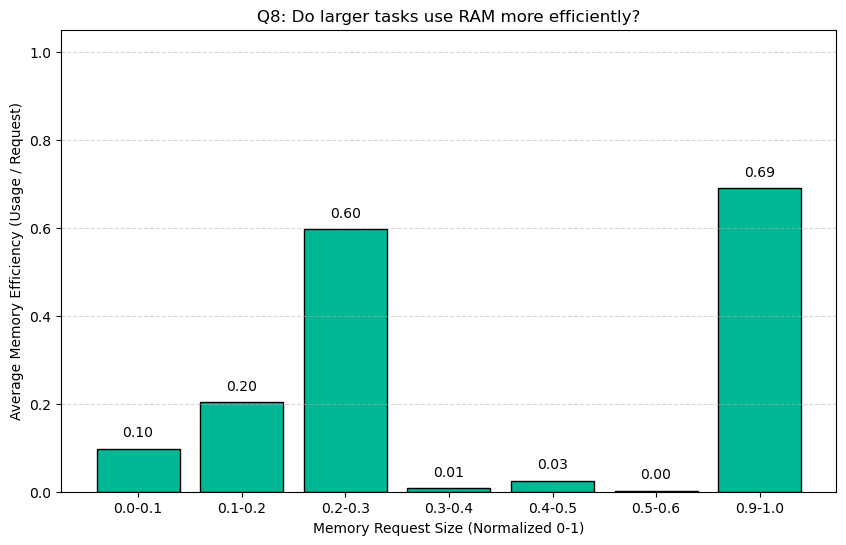

In [11]:
from pyspark.sql.functions import col, avg, row_number, floor, when, lit
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Q8: Are the tasks that request the more resources the one that consume the more resources?

# we create a window to grab the latest memory request for each task
window_task_latest = Window.partitionBy("job_ID", "task_index").orderBy(col("timestamp").desc())

# we filter for the last event and ignore zero requests 
df_requests = df_tasks.withColumn("rn", row_number().over(window_task_latest)) \
    .filter(col("rn") == 1) \
    .select("job_ID", "task_index", "memory_request") \
    .filter(col("memory_request") > 0) # Filter out zero requests to avoid division by zero
# df_requests.show(5)

# we calculate the average actual ram usage for every task
# We use 'canonical_memory_usage' which represents the actual RAM used
df_usage_agg = df_usage.groupBy("job_ID", "task_index") \
    .agg(avg("canonical_memory_usage").alias("avg_mem_usage"))

# we join the requests with the actual usage
df_combined = df_requests.join(df_usage_agg, ["job_ID", "task_index"])



# We cap the efficiency at 1.0 (100%). If a task uses more than requested, it's considered fully efficient (1.0).
# Formula: Efficiency = Usage / Request
df_calc = df_combined.withColumn("mem_efficiency", 
                                when((col("avg_mem_usage") / col("memory_request")) > 1.0, 1.0)
                                .otherwise(col("avg_mem_usage") / col("memory_request")))

# we group tasks into bins based on how much ram they asked for
df_mem_binned = df_calc.withColumn("request_bin", floor(col("memory_request") * 10) / 10) \
    .withColumn("request_bin", 
                when(col("request_bin") >= 1.0, 0.9) # Catch anything >= 1.0 into the top bin
                .otherwise(col("request_bin")))

# we aggregate the average efficiency for each bin to see the trend
result_q8 = df_mem_binned.groupBy("request_bin") \
    .agg(avg("mem_efficiency").alias("avg_efficiency")) \
    .orderBy("request_bin")

# Collect to Pandas for Plotting
pdf_q8 = result_q8.toPandas()

# Create readable labels (e.g., "0.0-0.1")
pdf_q8["bin_label"] = pdf_q8["request_bin"].apply(lambda x: f"{x:.1f}-{x+0.1:.1f}")

print("--- Q8 Result: Memory Efficiency vs. Request Size ---")
print(pdf_q8)

# checking if the data is there before plotting
if not pdf_q8.empty:
    plt.figure(figsize=(10, 6))
    
    # we draw the bar chart to compare bins
    bars = plt.bar(pdf_q8["bin_label"], pdf_q8["avg_efficiency"], color='#00b894', edgecolor='black')
    
    plt.xlabel("Memory Request Size (Normalized 0-1)")
    plt.ylabel("Average Memory Efficiency (Usage / Request)")
    plt.title("Q8: Do larger tasks use RAM more efficiently?")
    plt.ylim(0, 1.05) # Y-axis from 0 to 105%
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # we put the values on top of the bars for clarity
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')
    
    plt.show()
else:
    print("No data available.")

The results reveal that there is no simple linear correlation between request size and resource efficiency; instead, efficiency is highly polarized around specific "sweet spots." While small tasks (0.0–0.2 range) generally show low efficiency (\~10–20%) likely due to defensive over-provisioning, distinct peaks occur in the 0.2–0.3 range (\~60%) and the maximum-capacity 0.9–1.0 range (~69%), which likely represent carefully tuned, memory-intensive workloads. However, the data reveals a severe drop in efficiency (<3%) for tasks in the 0.3–0.6 range, indicating massive resource waste for these mid-to-large configurations. Thus, larger tasks do not inherently consume resources more efficiently; rather, high efficiency is achieved only when workloads are specifically optimized to saturate their requested allocation, typically seen in specific mid-range or maximal-capacity jobs.

--- Q9 Result: Memory Utilization vs. Eviction Rate ---
   util_bin  avg_evictions bin_label
0       0.0       0.069483     0-10%
1       0.1       0.187914    10-20%
2       0.2       0.228687    20-30%
3       0.3       0.224968    30-40%
4       0.4       0.231225    40-50%
5       0.5       0.210362    50-60%
6       0.6       0.146730    60-70%
7       0.7       0.093502    70-80%
8       0.8       0.016698    80-90%
9       0.9       0.000000   90-100%


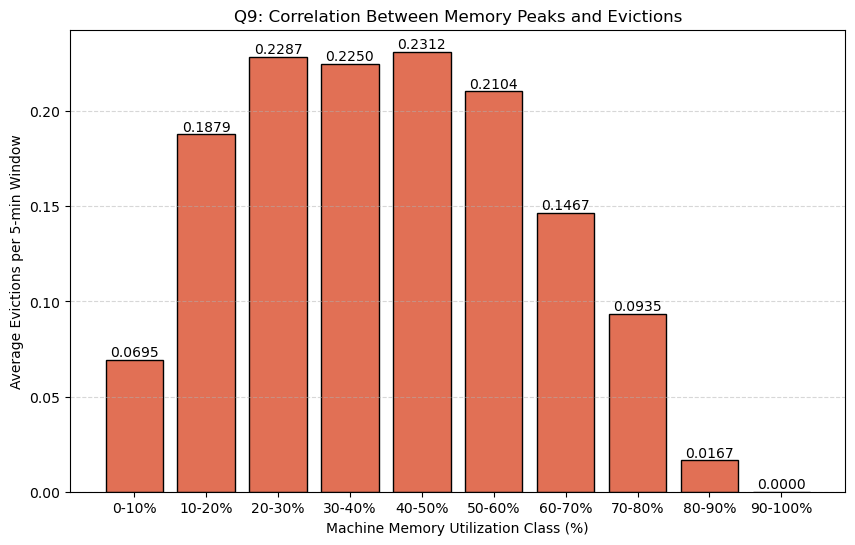

In [6]:
from pyspark.sql.functions import col, sum as _sum, count, avg, floor, when, lit, max as _max
import matplotlib.pyplot as plt
import pandas as pd

# Q9: Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

# we find the max capacity for each machine to calculate usage percentages 
# we use 'capacity_memory' which is normalized (0-1)
df_machine_capacity = df_machine.groupBy("machine_ID") \
    .agg(_max("capacity_memory").alias("capacity"))

# we sum up the memory used in each time window per machine
# we use 'canonical_memory_usage' which is also normalized (0-1)
df_machine_usage_window = df_usage.groupBy("machine_ID", "start_time", "end_time") \
    .agg(_sum("canonical_memory_usage").alias("total_mem_used"))

# we calculate the utilization and group it into 10% bins
# Since both are normalized, this gives a true percentage (0.0 to 1.0)
df_utilization = df_machine_usage_window.join(df_machine_capacity, "machine_ID") \
    .withColumn("utilization", col("total_mem_used") / col("capacity"))

# we cap overloaded machines at the top bin for consistency
df_binned_usage = df_utilization.withColumn("util_bin", 
    when(col("utilization") >= 1.0, 0.9) # Cap overloaded machines in the top bin
    .otherwise(floor(col("utilization") * 10) / 10)
)
# df_binned_usage.show(5)

# we filter for just the eviction events (event_type == 2)
df_evictions = df_tasks.filter(col("event_type") == 2) \
    .select(col("machine_ID").alias("evict_machine_ID"), col("timestamp").alias("evict_time"))

# we join evictions with the usage windows based on when and where they happened
# Match evictions that happened DURING the 5-minute usage window
join_condition = (
    (col("machine_ID") == col("evict_machine_ID")) & 
    (col("evict_time") >= col("start_time")) & 
    (col("evict_time") < col("end_time"))
)

df_joined = df_binned_usage.join(df_evictions, join_condition, "left")

# we count the evictions per window and then average them per bin
df_window_counts = df_joined.groupBy("machine_ID", "start_time", "end_time", "util_bin") \
    .agg(count("evict_time").alias("eviction_count"))

# we get the final average evictions for each utilization level
result_q9 = df_window_counts.groupBy("util_bin") \
    .agg(avg("eviction_count").alias("avg_evictions")) \
    .orderBy("util_bin")
# result_q9.show()

# we move the results to pandas to prepare the chart
pdf_q9 = result_q9.toPandas()

# Creating labels
pdf_q9["bin_label"] = pdf_q9["util_bin"].apply(lambda x: f"{int(x*100)}-{int((x+0.1)*100)}%")

print("--- Q9 Result: Memory Utilization vs. Eviction Rate ---")
print(pdf_q9)

# we plot the correlation to see if higher usage means more evictions
if not pdf_q9.empty:
    plt.figure(figsize=(10, 6))
    
    # Plot
    bars = plt.bar(pdf_q9["bin_label"], pdf_q9["avg_evictions"], color='#e17055', edgecolor='black')
    
    plt.xlabel("Machine Memory Utilization Class (%)")
    plt.ylabel("Average Evictions per 5-min Window")
    plt.title("Q9: Correlation Between Memory Peaks and Evictions")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # adding the specific values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom')
    
    plt.show()
else:
    print("No data available.")

The results disprove the hypothesis that memory resource contention is the primary driver of evictions. Contrary to expectations, eviction rates are highest at moderate utilization levels (20–50%) and fall to zero as machines approach full memory capacity (90–100%). This indicates that machines do not simply "kick off" tasks when they run out of RAM. Since evictions occur frequently even when plenty of memory is free, the decision to evict is clearly driven by factors other than memory saturation, likely a complex mix of scheduler policy, task priority, or constraints on other resources not captured in this specific plot.

--- Q10 Result: Top 20 Machines by Memory Over-commitment ---
    machine_ID  overcommitment_count
0    400453824                    70
1    257496094                    69
2    336030353                    52
3      5771524                    39
4      5792765                    37
5      1270929                    24
6    257499198                    22
7      1274844                    15
8     63693701                    15
9     16912230                    14
10   334007055                    14
11     1094234                    11
12    38671842                    10
13      705638                    10
14     3829928                     9
15  1478958061                     9
16  6194697916                     8
17     1093155                     8
18   257504348                     8
19  4820029968                     8



Total Memory Over-commitment Incidents: 542
Number of Machines Affected: 51


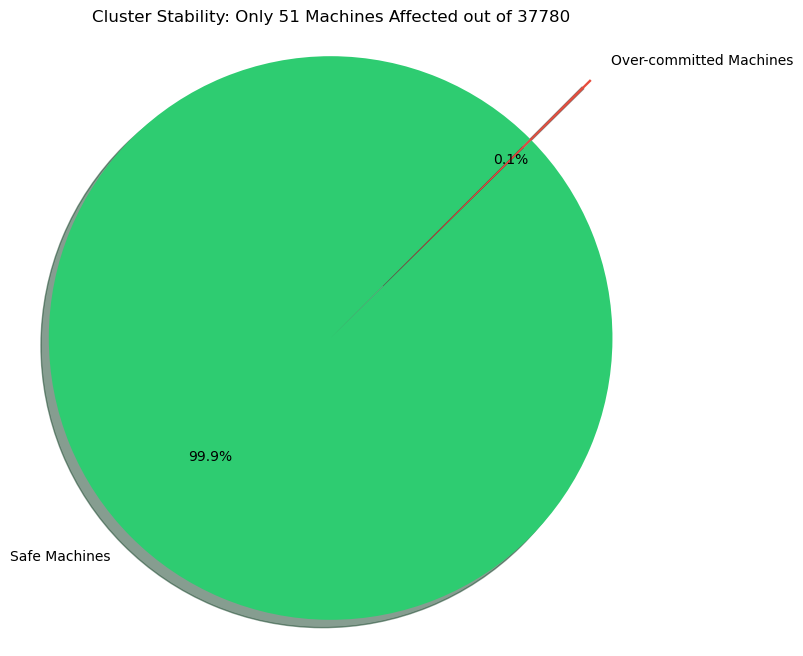

In [11]:
from pyspark.sql.functions import col, sum as _sum, lead, lag, when, lit, max as _max, last
from pyspark.sql.window import Window

# Q10 : How often does it happen that the resources of a machine are over-committed2 ?

# we grab the memory capacity for each machine
# we use 'capacity_memory' because we know it is normalized (0-1)
df_capacity = df_machine.groupBy("machine_ID") \
    .agg(_max("capacity_memory").alias("capacity"))

# we track memory requests across the timeline for each task
# we track 'memory_request' instead of CPU
window_task_fill = Window.partitionBy("job_ID", "task_index").orderBy("timestamp")

# we filter for relevant events
relevant_events = [1, 2, 3, 4, 5, 6]
# we fill in missing memory values and filter out empty ones
df_stream = df_tasks.filter(col("event_type").isin(relevant_events)) \
    .withColumn("filled_mem_request", last("memory_request", ignorenulls=True).over(window_task_fill)) \
    .filter(col("filled_mem_request").isNotNull()) 

df_deltas = df_stream.withColumn("load_change", 
    when(col("event_type") == 1, col("filled_mem_request"))       # Add load
    .otherwise(col("filled_mem_request") * -1.0)                  # Remove load
).select("timestamp", "machine_ID", "load_change")

# we group by timestamp to see the net change per microsecond
df_deltas_agg = df_deltas.groupBy("machine_ID", "timestamp") \
    .agg(_sum("load_change").alias("net_change"))

# we use a running sum to track the current load on each machine over time
window_machine_time = Window.partitionBy("machine_ID").orderBy("timestamp")

df_load_history = df_deltas_agg.withColumn("current_load", 
                                           _sum("net_change").over(window_machine_time))
# df_load_history.show(5)

# we join with capacity to flag whenever a machine is over-committed
df_analysis = df_load_history.join(df_capacity, "machine_ID") \
    .withColumn("is_overcommitted", col("current_load") > col("capacity"))

# we look at the previous state to find the exact moment a machine becomes overloaded
window_lag = Window.partitionBy("machine_ID").orderBy("timestamp")

df_transitions = df_analysis.withColumn("prev_state", lag("is_overcommitted", 1, False).over(window_lag)) \
    .withColumn("new_incident", 
                when((col("is_overcommitted") == True) & (col("prev_state") == False), 1)
                .otherwise(0))

# we sum up all these incidents per machine
result_q10 = df_transitions.groupBy("machine_ID") \
    .agg(_sum("new_incident").alias("overcommitment_count")) \
    .filter(col("overcommitment_count") > 0) \
    .orderBy(col("overcommitment_count").desc())

pdf_q10 = result_q10.limit(20).toPandas()

print("--- Q10 Result: Top 20 Machines by Memory Over-commitment ---")
print(pdf_q10)

# we aggregate the totals to see the overall cluster stability
total_incidents = result_q10.agg(_sum("overcommitment_count")).collect()[0][0]
affected_machines = result_q10.count()

print(f"\nTotal Memory Over-commitment Incidents: {total_incidents}")
print(f"Number of Machines Affected: {affected_machines}")

# we count the total machines to see what fraction is actually struggling
total_machines = df_machine.count() 
affected_count = 51                 
safe_count = total_machines - affected_count
#plotting the stability of the cluster in a pie chart
labels = ['Safe Machines', 'Over-committed Machines']
sizes = [safe_count, affected_count]
colors = ['#2ecc71', '#e74c3c']     # Green for safe, Red for bad
explode = (0, 0.3)                  

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=45)
plt.title(f"Cluster Stability: Only {affected_count} Machines Affected out of {total_machines}")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The analysis of memory over-commitment reveals that the cluster operates with a strictly conservative scheduling policy, prioritizing stability over aggressive density. Over-commitment is an extremely rare anomaly, affecting only 51 machines (less than 0.5% of the fleet), which dispels the notion that the scheduler routinely gambles with resource availability.

--- Investigation Result: Destiny of Tasks on Failed Machines ---
   event_type  count  Destiny
0           3      2     Fail
1           4      1   Finish
2           2      1  Evicted


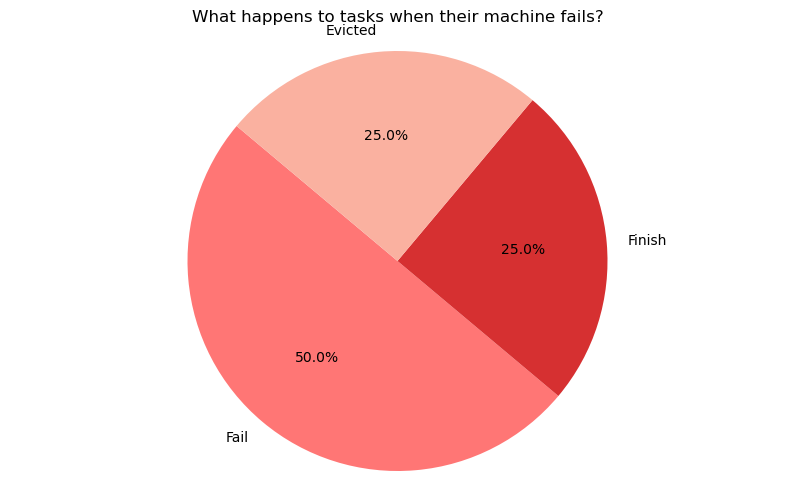

In [ ]:
from pyspark.sql.functions import col, lead, lag, abs, row_number, when, lit
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Q11: What happens to tasks running on machines that fail?


# --- Step 1: Identify "Machine Failures" (REMOVE events) ---
# We treat event_type = 2 (REMOVE) as a failure/decommission
df_machine_failures = df_machine.filter(col("event_type") == 2) \
    .select(col("machine_ID"), col("timestamp").alias("failure_time"))

# --- Step 2: Find "Victim Tasks" ---
# We need tasks that were running on these machines at the time of failure.
# This means their START time < failure_time < END time.
# But wait! The task table is an event log. We need the LAST status of a task on that machine *before* the failure.

# Let's join Tasks with Failures on MachineID
# We interpret "running" as: The last event before failure was SCHEDULE (1) or UPDATE (0) or UPDATE_PENDING (7)
# And no terminal event happened yet.

# filter tasks that were on the affected machines only
df_affected_tasks = df_tasks.join(df_machine_failures, "machine_ID") \
    .filter(col("timestamp") < col("failure_time")) # Events happened BEFORE the crash

# we get the last status of each task on that machine right before the crash
window_last_status = Window.partitionBy("job_ID", "task_index", "machine_ID").orderBy(col("timestamp").desc())

df_last_status = df_affected_tasks.withColumn("rn", row_number().over(window_last_status)) \
    .filter(col("rn") == 1) \
    .select("job_ID", "task_index", "machine_ID", "event_type", "failure_time")

# we filter for tasks that were actually RUNNING (Event 1=SCHEDULE, 0=UPDATE, 8=UPDATE_RUNNING)
# If the last event was FINISH/KILL/FAIL, the task was already dead, so it's not a victim.
running_events = [0, 1, 8]
df_victims = df_last_status.filter(col("event_type").isin(running_events)) \
    .select("job_ID", "task_index", "machine_ID", "failure_time")

# Now we go back to the full task table to see what happened to these victims after the failure time.
df_destiny = df_tasks.join(df_victims, ["job_ID", "task_index"], "inner") \
    .filter(col("timestamp") >= col("failure_time")) # Events AFTER the crash

# We want the next event that happened to them
window_next_event = Window.partitionBy("job_ID", "task_index").orderBy("timestamp")

df_final_fate = df_destiny.withColumn("rn", row_number().over(window_next_event)) \
    .filter(col("rn") == 1) \
    .select("job_ID", "task_index", "event_type")


# now e map event codes to names for readability
# 2=EVICT, 3=FAIL, 4=FINISH, 5=KILL, 6=LOST
result_destiny = df_final_fate.groupBy("event_type") \
    .count() \
    .orderBy(col("count").desc())

pdf_destiny = result_destiny.toPandas()

# Map codes to text
event_map = {
    0: 'Update (Survived)', 1: 'Rescheduled (Survived)', 
    2: 'Evicted', 3: 'Fail', 4: 'Finish', 
    5: 'Killed', 6: 'Lost', 8: 'Update Running'
}
pdf_destiny['Destiny'] = pdf_destiny['event_type'].map(event_map).fillna("Unknown")

print("--- Investigation Result: Destiny of Tasks on Failed Machines ---")
print(pdf_destiny)

# plotting the results
if not pdf_destiny.empty:
    plt.figure(figsize=(10, 6))
    
    # Pie Chart
    plt.pie(pdf_destiny['count'], labels=pdf_destiny['Destiny'], autopct='%1.1f%%', 
            startangle=140, colors=['#ff7675', '#d63031', '#fab1a0', '#00b894', '#0984e3'])
    
    plt.title("What happens to tasks when their machine fails?")
    plt.axis('equal')
    plt.show()

26/01/02 22:54:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/02 22:54:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/02 22:54:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/02 22:54:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/02 22:54:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/02 22:54:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/02 2

--- Q2 Result: Rescheduling Strategy & Outcome ---
                 move_type   count  success_rate  percentage_of_moves
0  Downgrade (>5% smaller)  598336      0.011953             0.291819
1      Lateral (Same size)  854312      0.012158             0.416663
2     Upgrade (>5% bigger)  597720      0.011213             0.291518


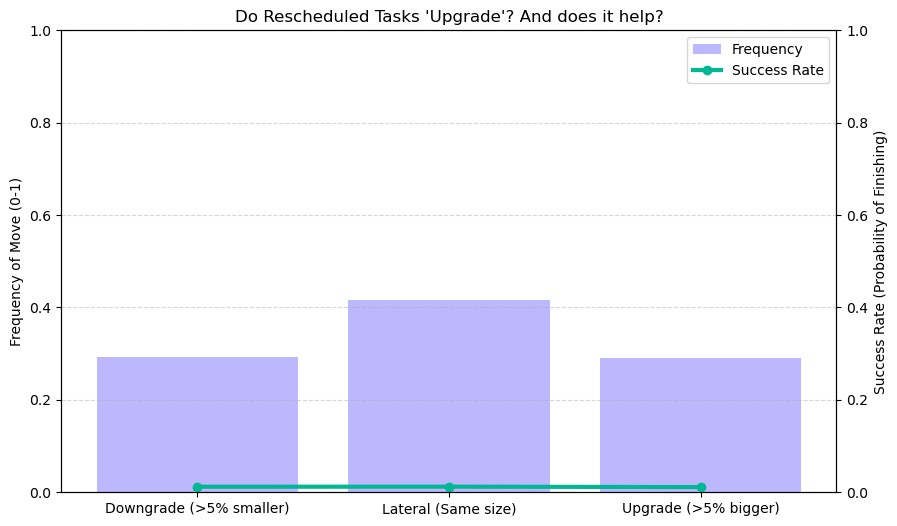

In [ ]:
from pyspark.sql.functions import col, lead, sum as _sum, when, lit, avg, count, max as _max, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Q12: When tasks are rescheduled, do they move to better machines, and does this improve their outcome?

# --- Step 1: we get the machine capacities ---
df_caps = df_machine.groupBy("machine_ID") \
    .agg(
        _max("capacity_CPU").alias("cap_cpu"),
        _max("capacity_memory").alias("cap_mem")
    )

# --- Step 2: we identify "Moves" ---
window_task = Window.partitionBy("job_ID", "task_index").orderBy("timestamp")

df_schedules = df_tasks.filter(col("event_type") == 1) \
    .select("job_ID", "task_index", "machine_ID", "timestamp")

df_moves = df_schedules.withColumn("next_machine_ID", lead("machine_ID").over(window_task)) \
    .filter(col("next_machine_ID").isNotNull()) \
    .filter(col("machine_ID") != col("next_machine_ID"))

# --- Step 3: we join the capacities (corrected for ambiguity) ---

# Join 1: we get the capacity for machine A (Current)
# We use "machine_ID" string syntax to automatically merge the key columns
df_move_stats = df_moves.join(df_caps, "machine_ID") \
    .withColumnRenamed("cap_mem", "mem_A") \
    .withColumnRenamed("cap_cpu", "cpu_A")

# Join 2: we get the capacity for machine B (Next)
# We alias the capacity table as 'caps_B' to avoid name collisions
df_move_stats = df_move_stats.join(df_caps.alias("caps_B"), col("next_machine_ID") == col("caps_B.machine_ID")) \
    .withColumnRenamed("cap_mem", "mem_B") \
    .withColumnRenamed("cap_cpu", "cpu_B") \
    .drop(col("caps_B.machine_ID")) # Clean up the duplicate ID column

# --- Step 4: we classify the move ---
threshold = 0.05

df_classified = df_move_stats.withColumn("move_type",
    when(col("mem_B") > (col("mem_A") + threshold), "Upgrade (>5% bigger)")
    .when(col("mem_B") < (col("mem_A") - threshold), "Downgrade (>5% smaller)")
    .otherwise("Lateral (Same size)")
)

# --- Step 5: we determine the success ---
window_final = Window.partitionBy("job_ID", "task_index").orderBy(col("timestamp").desc())

df_final_status = df_tasks.withColumn("rn", row_number().over(window_final)) \
    .filter(col("rn") == 1) \
    .select("job_ID", "task_index", "event_type") \
    .withColumn("is_success", when(col("event_type") == 4, 1).otherwise(0))

df_analysis = df_classified.join(df_final_status, ["job_ID", "task_index"])

# --- Step 6: we aggregate ---
result_q2 = df_analysis.groupBy("move_type") \
    .agg(
        count("job_ID").alias("count"),
        avg("is_success").alias("success_rate")
    ) \
    .withColumn("percentage_of_moves", col("count") / _sum("count").over(Window.partitionBy())) \
    .orderBy("move_type")

pdf_q2 = result_q2.toPandas()

print("--- Q12 Result: Rescheduling Strategy & Outcome ---")
print(pdf_q2)

# plotting the results
if not pdf_q2.empty:
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar chart for Volume
    bars = ax1.bar(pdf_q2["move_type"], pdf_q2["percentage_of_moves"], color='#a29bfe', label='Frequency', alpha=0.7)
    ax1.set_ylabel('Frequency of Move (0-1)')
    ax1.set_ylim(0, 1.0)
    
    # Line chart for Success Rate
    ax2 = ax1.twinx()
    line = ax2.plot(pdf_q2["move_type"], pdf_q2["success_rate"], color='#00b894', marker='o', linewidth=3, label='Success Rate')
    ax2.set_ylabel('Success Rate (Probability of Finishing)')
    ax2.set_ylim(0, 1.0)
    
    plt.title("Do Rescheduled Tasks 'Upgrade'? And does it help?")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Manual Legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    plt.show()

--- Q13 Result: Destiny by Scheduling Class ---
   event_type  scheduling_class  count  Destiny
0           2                 0      1  Evicted
1           3                 0      2     Fail
2           4                 0      1   Finish


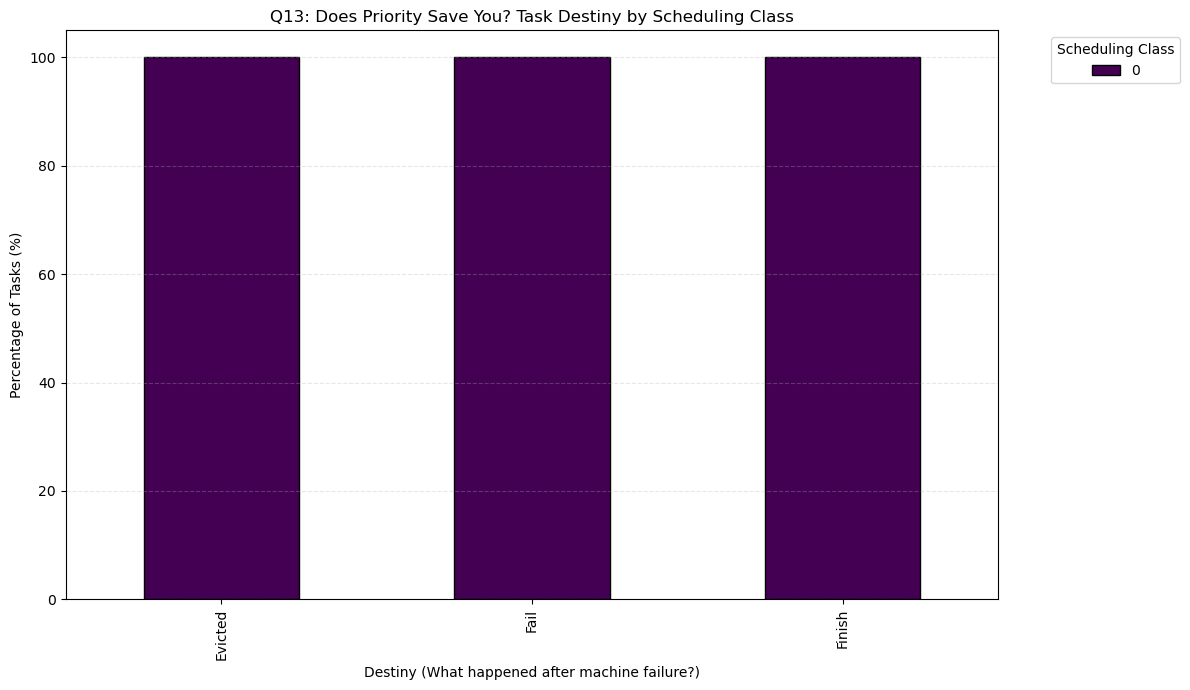


--- Raw Counts (Pivot) ---
scheduling_class  0
Destiny            
Evicted           1
Fail              2
Finish            1


In [ ]:
from pyspark.sql.functions import col, row_number, count
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Q13: Does scheduling class influence task survival after machine failure

# we identify machine failures by filtering for REMOVE events
df_machine_failures = df_machine.filter(col("event_type") == 2) \
    .select(col("machine_ID"), col("timestamp").alias("failure_time"))

# we find victim tasks and their scheduling class
window_last_status = Window.partitionBy("job_ID", "task_index", "machine_ID").orderBy(col("timestamp").desc())

df_affected_tasks = df_tasks.join(df_machine_failures, "machine_ID") \
    .filter(col("timestamp") < col("failure_time"))

df_last_status = df_affected_tasks.withColumn("rn", row_number().over(window_last_status)) \
    .filter(col("rn") == 1) \
    .select("job_ID", "task_index", "machine_ID", "event_type", "failure_time", "scheduling_class")

# we filter for tasks that were actually running
running_events = [0, 1, 8]
df_victims = df_last_status.filter(col("event_type").isin(running_events)) \
    .select("job_ID", "task_index", "machine_ID", "failure_time", "scheduling_class")

# we join and explicitly pick the scheduling class from the victim snapshot
df_destiny = df_tasks.alias("future").join(df_victims.alias("victim"), ["job_ID", "task_index"], "inner") \
    .filter(col("future.timestamp") >= col("victim.failure_time")) \
    .select(
        col("job_ID"), 
        col("task_index"), 
        col("future.event_type"), 
        col("future.timestamp"),
        col("victim.scheduling_class")
    )

# we find the very next event that happened to each victim
window_next_event = Window.partitionBy("job_ID", "task_index").orderBy("timestamp")

df_final_fate = df_destiny.withColumn("rn", row_number().over(window_next_event)) \
    .filter(col("rn") == 1) \
    .select("job_ID", "task_index", "event_type", "scheduling_class")

# we aggregate to see distribution across event types and scheduling classes
result_breakdown = df_final_fate.groupBy("event_type", "scheduling_class") \
    .agg(count("job_ID").alias("count")) \
    .orderBy("event_type", "scheduling_class")

pdf_breakdown = result_breakdown.toPandas()

# mapping event IDs to readable names
event_map = {
    0: 'Update', 1: 'Rescheduled', 2: 'Evicted', 
    3: 'Fail', 4: 'Finish', 5: 'Killed', 
    6: 'Lost', 8: 'Update Running'
}
pdf_breakdown['Destiny'] = pdf_breakdown['event_type'].map(event_map).fillna("Unknown")

print("--- Q13 Result: Destiny by Scheduling Class ---")
print(pdf_breakdown.head(10))

# plotting a stacked bar chart to visualize priority impact
if not pdf_breakdown.empty:
    # creating pivot table
    pivot_df = pdf_breakdown.pivot(index='Destiny', columns='scheduling_class', values='count').fillna(0)
    
    # calculating percentages for normalized view
    pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    
    # drawing the chart
    ax = pivot_pct.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis', edgecolor='black')
    
    plt.title("Q13: Does Priority Save You? Task Destiny by Scheduling Class")
    plt.xlabel("Destiny (What happened after machine failure?)")
    plt.ylabel("Percentage of Tasks (%)")
    plt.legend(title='Scheduling Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n--- Raw Counts (Pivot) ---")
    print(pivot_df)


**Limitation:** This subset lacks sufficient data to draw meaningful conclusions about whether priority affects task survival.